In [34]:
import os
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, IterableDataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt


In [ ]:
!unzip /content/drive/MyDrive/ACV/data40000.zip -d /content/

In [ ]:
!unzip /content/drive/MyDrive/ACV/testdata.zip -d /content/
!rm /content/testdata/.DS_Store

In [ ]:
!unzip /content/drive/MyDrive/ACV/fundata.zip -d /content/
!rm /content/fundata/.DS_Store

In [48]:
train_path = "/content/out"
explore_path = "/content/testdata"
fun_path = "/content/fundata"
save_path = "/content/checkpoints/my.ckpt"

In [49]:
alphabet = """abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 .$-',"();#:!?+*/%"""
out_classes = len(alphabet)

# Utils

I took the below class directly from https://github.com/meijieru/crnn.pytorch/blob/master/utils.py (Paper's pytorch implementation) with some modifications of my own.


In [50]:
class Converter(object):
    def __init__(self, alphabet):
        self.alphabet = alphabet + '-'  # for `-1` index
        self.dict = {}
        for i, char in enumerate(alphabet):
            self.dict[char] = i + 1
        self.dict[''] = 0
    def encode(self, text):
        """Support batch or single str.
        Args:
            text (str or list of str): texts to convert.
        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        '''
        if isinstance(text, str):
            text = [
                self.dict[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))
        '''
        length = []
        result = []
        for item in text:
            length.append(len(item))
            for char in item:
                if char in self.dict:
                    index = self.dict[char]
                else:
                    index = 0
                result.append(index)

        text = result
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.
        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        Raises:
            AssertionError: when the texts and its length does not match.
        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts

# Data

In [51]:
class collator(object):
    def __call__(self, batch):
        # from dataset
        w = [item['img'].shape[2] for item in batch]
        idxs = [item['idx'] for item in batch]
        
        # batch, channel, height, width
        imgs = torch.ones([len(batch), batch[0]['img'].shape[0], batch[0]['img'].shape[1], 
                           max(w)], dtype=torch.float32).cuda()

        # assign
        for i, v in enumerate(batch):
              # data is not the same width
              imgs[i, :, :, 0:v['img'].shape[2]] = v['img']
        
        labels = [item['label'] for item in batch]
        item = {'img': imgs, 'idx':idxs, 'label': labels}
  
        return item

In [52]:
class myDataset(Dataset):
  def __init__(self, path):
      super(myDataset, self).__init__()
      # parent dic
      self.path = path

      # all image paths
      paths = os.listdir(self.path)

      # num of images
      self.nImages = len(paths)

      # image full paths
      self.paths = list(map(lambda x: os.path.join(self.path, x), paths))

      # first grayscale
      # then bring the range down from 255 to 1
      self.transform = transforms.Compose([transforms.Grayscale(1),
                          transforms.ToTensor(), 
                          transforms.Normalize(0.5, 0.5)])
      
  def __getitem__(self, index):
      imagepath = self.paths[index]
      imagefile = os.path.basename(imagepath)
      img = Image.open(imagepath)
      img = self.transform(img)
      # make all imgs same height, required by model
      t = transforms.Resize((32, img.shape[2]))
      img = t(img)

      item = {'img': img, 'idx':index}
      item['label'] = imagefile.split('_')[0]
      return item 
  
  def __len__(self):
      return self.nImages


In [53]:
data = myDataset(train_path)
data_train, data_test = random_split(data, [0.7, 0.3])
len(data_train)


28000

# Model

Implmented base on Shi et al. paper

In [54]:
class BLSTM(nn.Module):
    def __init__(self, nIn, nHidden, nOut):
        super(BLSTM, self).__init__()
        
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        self.rnn.flatten_parameters()
        res, _ = self.rnn(input)
        T, b, n = res.size()
        # reshape the output to [T * b, num of classes] for hidden layer
        inp = res.view(T * b, n)
        output = self.embedding(inp)  
        
        #bring back the size 
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, out_classes):
        super(CRNN, self).__init__()
        cnn = nn.Sequential()

        # 0
        cnn.add_module('conv0', nn.Conv2d(1, 64, 3, 1, 1))
        cnn.add_module('relu0', nn.ReLU(True))

        cnn.add_module('pooling0', nn.MaxPool2d(2, 2))  

        # 1
        cnn.add_module('conv1', nn.Conv2d(64, 128, 3, 1, 1))
        cnn.add_module('relu1', nn.ReLU(True))

        cnn.add_module('pooling1', nn.MaxPool2d(2, 2))  
        
        #2 
        cnn.add_module('conv2', nn.Conv2d(128, 256, 3, 1, 1))
        cnn.add_module('batchnorm2', nn.BatchNorm2d(256))
        cnn.add_module('relu2', nn.ReLU(True))

        #3
        cnn.add_module('conv3', nn.Conv2d(256, 256, 3, 1, 1))
        cnn.add_module('relu3', nn.ReLU(True))

        cnn.add_module('pooling3', nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  
        
        #4
        cnn.add_module('conv4', nn.Conv2d(256, 512, 3, 1, 1))
        cnn.add_module('batchnorm4', nn.BatchNorm2d(512))
        cnn.add_module('relu4', nn.ReLU(True))

        #5
        cnn.add_module('conv5', nn.Conv2d(512, 512, 3, 1, 1))
        cnn.add_module('relu5', nn.ReLU(True))
        cnn.add_module('pooling5', nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  
        
        #6
        cnn.add_module('conv6', nn.Conv2d(512, 512, 2, 1, 0))
        cnn.add_module('batchnorm6', nn.BatchNorm2d(512))
        cnn.add_module('relu6', nn.ReLU(True))

        
        self.cnn = cnn
        self.rnn = nn.Sequential(
            BLSTM(512, 256, 256),
            BLSTM(256, 256, out_classes))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  

        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) 

        return output

# Training

In [55]:
model = CRNN(out_classes).cuda()
criterion = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)
converter = Converter(alphabet)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs =8
batch_size = 32
# model

In [42]:
def forward(x):
    # forward pass of the model
    res = model(x)
    return res.transpose(1, 0)

def cal_loss(res, targets, pred_sizes, target_sizes):
    # calculate loss
    loss = criterion(res, targets, pred_sizes, target_sizes)
    return loss

def train_batch(batch):
    inputs, targets = batch['img'], batch['label']
    targets, target_size = converter.encode(targets)
    res = forward(inputs)

    # copy the data to cpu
    res = res.contiguous().cpu()

    # calculate probabbilities
    res = torch.nn.functional.log_softmax(res, 2)
    T, B, C = res.size()

    res_size = torch.LongTensor([T for i in range(B)])

    # also bring to cpu!
    targets= targets.view(-1).contiguous()

    loss = cal_loss(res, targets, res_size, target_size)
    return loss


def training_step(batch):
    loss = train_batch(batch)
    optimizer.zero_grad()
    loss.backward()
    # prevent gradient explode
    clip_grad_norm_(model.parameters(), 0.05)
    optimizer.step()
    return abs(loss.item())

In [ ]:
losses = []
# training loop
for epoch in range(0, epochs):
    pbar = None
    loader = torch.utils.data.DataLoader(data_train,
                batch_size=batch_size,
                collate_fn=collator(),
                shuffle=True)
    pbar = tqdm(loader, leave=True, total= len(loader))
    model.train()
    outputs = []

    for batch_nb, batch in enumerate(pbar):
        loss = training_step(batch)
        outputs.append(loss)

    losses.extend(outputs)

    train_result = np.mean(outputs)
    print('epoch = {}, train_loss = {}'.format(epoch, train_result)) 
    print("saving checkpoint")
    torch.save(model.state_dict(), save_path)
    

In [ ]:
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("CTC loss")
plt.title("loss change during training ")
plt.show()


# Test

In [56]:
# load model
model = CRNN(out_classes).cuda()
model.load_state_dict(torch.load(save_path))
model.eval()

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling3): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.

In [57]:
def diff(labels, preds):
    # return char accuracy and word accuracy
    i_total = len(preds)
    i_correct = 0
    c_total = 0
    c_correct = 0
    for a, b in zip(labels, preds):
        c_total += len(a)
        if a == b:
          i_correct+=1
          c_correct+= len(a)
        else:
          for x, y in zip(a, b):
            if a == b:
              c_correct+= 1

    return c_correct/c_total, i_correct/i_total




In [58]:
labels, preds = [], []

# test dataloader
loader = torch.utils.data.DataLoader(data_test,
            batch_size=batch_size,
            collate_fn=collator())


for iteration, batch in enumerate(tqdm(loader)):
        input, out = batch['img'].cuda(), batch['label']
        labels.extend(out)

        res = model(input).transpose(1, 0)
        res = torch.nn.functional.log_softmax(res, 2)
        res = res.contiguous().cpu()

        T, B, H = res.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = res.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        preds.extend(sim_preds)

  0%|          | 0/375 [00:00<?, ?it/s]

In [60]:
# test accuracy 
c_acc, i_acc = diff(labels, preds)
print("Test\nchar accuracy: {} \nimage accuracy {}\n".format(c_acc, i_acc))

Test
char accuracy: 0.9537520676256317 
image accuracy 0.9519166666666666



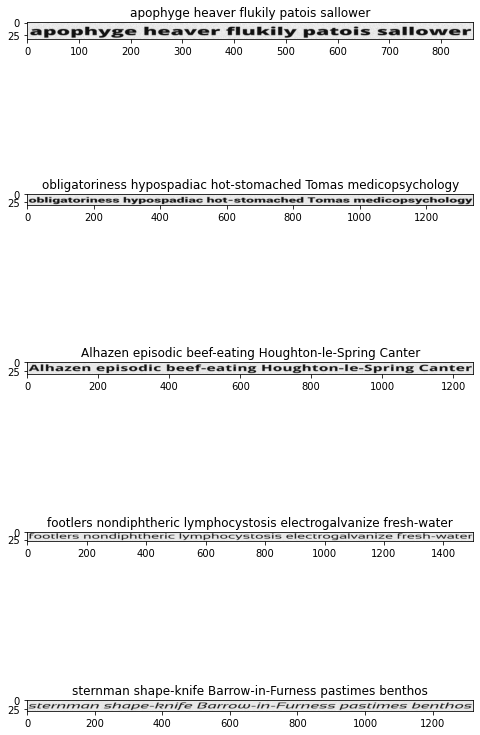

In [115]:
fig=plt.figure(figsize=(8, 15))
count = 5
for i in range(1, count +1):
    img = data_test[i]["img"].squeeze()
    fig.add_subplot(count, 1, i)
    plt.title(preds[i])
    plt.imshow(img, cmap='gray')
plt.show()

# Fun

In [20]:
data_fun = myDataset(explore_path)
data_fun

In [27]:
labels, preds = [], []

# validation dataloader
loader = torch.utils.data.DataLoader(data_fun,
            batch_size=batch_size,
            collate_fn=collator())


for iteration, batch in enumerate(tqdm(loader)):
        input, out = batch['img'].cuda(), batch['label']
        labels.extend(out)

        res = model(input).transpose(1, 0)
        res = torch.nn.functional.log_softmax(res, 2)
        res = res.contiguous().cpu()

        T, B, H = res.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = res.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        preds.extend(sim_preds)

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
# accuracy 
c_acc, i_acc = diff(labels, preds)
print("Fun\nchar accuracy: {} \nimage accuracy {}\n".format(c_acc, i_acc))

['boxing', 'jump', 'wizards', 'wizards', 'boxing', 'wizards', 'jump', 'the', 'quickly', 'the', 'five', 'boxing', 'quickly', 'wizards', 'boxing', 'five', 'wizards', 'jump', 'five', 'jump', 'wizards', 'wizards', 'wizards', 'boxing', 'quickly', 'quickly', 'the', 'jump', 'quickly', 'jump', 'five', 'the', 'the', 'the', 'jump', 'boxing', 'boxing', 'quickly', 'quickly', 'jump', 'wizards', 'wizards', 'boxing', 'the', 'five', 'the', 'boxing', 'jump', 'quickly', 'wizards', 'jump', 'boxing', 'jump', 'quickly', 'wizards', 'quickly', 'wizards', 'quickly', 'jump', 'five', 'quickly', 'boxing', 'quickly', 'boxing', 'wizards', 'jump', 'the', 'jump', 'jump', 'jump', 'jump', 'quickly', 'wizards', 'quickly', 'boxing', 'jump', 'quickly', 'the', 'quickly', 'five', 'jump', 'the', 'wizards', 'jump', 'wizards', 'five', 'quickly', 'the', 'jump', 'boxing', 'wizards', 'five', 'wizards', 'jump', 'jump', 'jump', 'wizards', 'five', 'quickly', 'five', 'wizards', 'wizards', 'jump', 'five', 'boxing', 'the', 'quickly', 

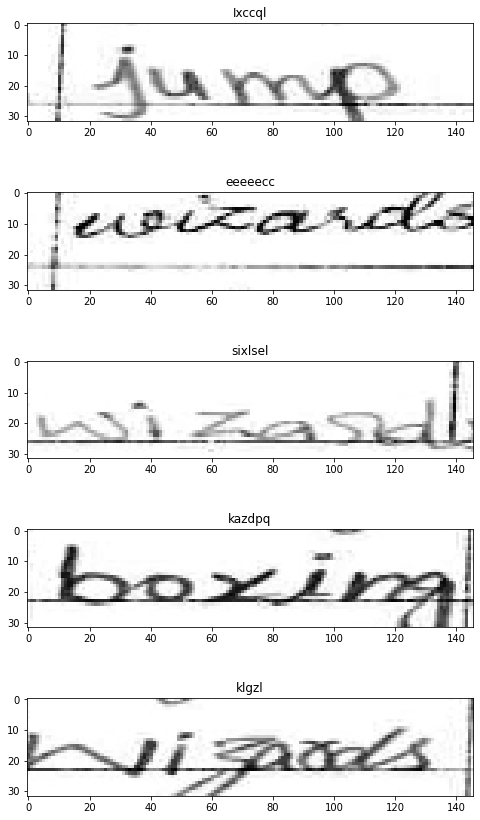

In [29]:
print(labels, preds)
fig=plt.figure(figsize=(8, 15))
count = 5
for i in range(1, count +1):
    img = data_fun[i]["img"].squeeze()
    fig.add_subplot(count, 1, i)
    print(i)
    plt.title(preds[i])
    plt.imshow(img, cmap='gray')
plt.show()

In [31]:
data_fun = myDataset(fun_path)
data_fun

In [32]:
labels, preds = [], []

# dataloader
loader = torch.utils.data.DataLoader(data_fun,
            batch_size=1,
            collate_fn=collator())


for iteration, batch in enumerate(tqdm(loader)):
        input, out = batch['img'].cuda(), batch['label']
        labels.extend(out)

        res = model(input).transpose(1, 0)
        res = torch.nn.functional.log_softmax(res, 2)
        res = res.contiguous().cpu()

        T, B, H = res.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = res.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        preds.extend(sim_preds)

  0%|          | 0/1 [00:00<?, ?it/s]

['DISTORTIVE BY THEIR NATURE.jpg'] ['o', 'i', 'o', 'r', 'o', 'z', 't', 'i', 'k', 't', ' ', 'b', 'y', ' ', 'i', 'h', 'e', 'i', 'r', ' ', 'h', 'p', 'i', 'k', 'e']


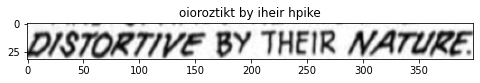

In [38]:
fig=plt.figure(figsize=(8, 15))
count = 1

img = data_fun[0]["img"].squeeze()
fig.add_subplot(count, 1, 1)
plt.title("".join(preds))
plt.imshow(img, cmap='gray')
plt.show()